### Title: "MAL 03"

| Gruppe 30 |
| --------- |

| Navn                    | Studienummer |
| ----------------------- | ------------ |
| Lasse Borring Petersen  | 202208165    |
| Benjamin Harboe Strunge | 202209864    |
| Esben Inglev            | 202210050    |
| Asbjørn Vad             | 202208512    |


# CNN

## Introduction to CNNs

Convolutional Neural Networks, or CNN's, are a class of neural networks, that work specifically well on tasks such as image recognition, speech recognition, object detection, and other similar tasks. In general, it is good at working with data that comes in a grid-like structure, since it works in 2D instead of 1D.

A CNN consists of several convolutional layers. A Convolutional layer is a layer of neurons, each looking at some smaller part of the data we want to analyze. Eg. if the data is an image, then a neuron might look at a small square of pixels in the corner, and the next neuron will look at the next small square of pixels, and so on. And then in the next convolutional layer, each neuron looks at a small subset of neurons from layer 1. The step size between each field that a neuron is connected to, is called the _stride_, as shown in the image below

<img src="img/CNN_Architecture.png" alt="CNN layer structure" width="500"/>

This convolution can be done using a kernel, which is a matrix of weights, corresponding to how much each field in the lower layer should 'matter', in the final value used in the upper layer on the image above.

A CNN can also have up to several pooling layers in its architecture. These layers are present to reduce the computational complexity of the CNN, as it can get extremely high, even with small sets of data. The idea is to reduce the dimensions of the feature maps, which can be done in some different ways. One of the most common forms is called _Max Pooling_, which is where the max value from a small region is chosen as that regions only data point. If the region is a 2x2 of inputs, then we have effectively reduced our input size by 75%.

#### Sources:

Chapter 14, HOML

Lesson 7 slides


### Model

Note that the following code is the CNN - after all iterations of having tried to maximize a high accuracy.


In [2]:
import keras
from keras import layers
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Generalization
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

model = keras.Sequential([
    layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    
    layers.Dropout(0.25),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax'),
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[callback])

results = model.evaluate(x_test, y_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,130 (1.59 MB)

 Trainable params: 417,018 (1.59 MB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: 0.2434 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.0667 - val_sparse_categorical_accuracy: 0.9819
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.0493 - val_sparse_categorical_accuracy: 0.9876
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.0475 - val_sparse_categorical_accuracy: 0.9875
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0436 - val_sparse_categorical_accuracy: 0.9882
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.0417 - val_sparse_categorical_accuracy: 0.9889
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.0354 - val_sparse_categoric

## Questions

### Usage of generalization

In the CNN, generalization is used to divide the dataset into training-, test- and validationdata. The training data is of course used to train the model, but the Keras Sequential class also supports using validation data while its training. It uses this to show the loss and accuracy value while its training, on data that it isnt used for training. We can use this to see how well the model generalizes during training.

If we see that the validation accuracy falls, while the training accuracy increases, we are likely overfitting, and we can catch it earlier than if we did not use a validation set while training.

Then we end it with testing our model on the test data, where we also get a loss and accuracy value. Here we measure how well the model does on completely new data, that wasnt used for either training or validation.

#### Sources

https://keras.io/guides/training_with_built_in_methods/

https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set

### Optimization of results towards high accuracy

The first model that was tested, which's code was largely inspired by the slides, looking like this:

```python
model = keras.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.AveragePooling2D(pool_size=(3,3)),
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.AveragePooling2D(pool_size=(3,3)),
    layers.Flatten(),
    layers.Dense(units=120, activation='relu'),
    layers.Dense(units=84, activation='relu'),
    layers.Dense(units=10, activation='softmax'),
])
```

#### Table of iterations towards a high accuracy

| Change                                                                                                     | Loss  | Accuracy | Comment                                                                                                            |
| ---------------------------------------------------------------------------------------------------------- | ----- | -------- | ------------------------------------------------------------------------------------------------------------------ |
| First model                                                                                                | 0.064 | 0.981    | Benchmark for other results                                                                                        |
| Increase epoch count from 5 to 10                                                                          | 0.061 | 0.983    | Improvement, but also significant increase in runtime.                                                             |
| Change AveragePooling2D layer to MaxPooling2D                                                              | 0.087 | 0.974    | Worse than benchmark result, therefore reverted.                                                                   |
| Change AveragePooling2D to BatchNormalization, increase filter count from 6, 16 to 16, 32.                 | 0.108 | 0.975    | Increased loss and decreased accuracy. Also increased time to train significantly. Reverted.                       |
| Remove middle Dense layer, add two dropout layers.                                                         | 0.052 | 0.984    | Improvement to both loss and accuracy, changes kept.                                                               |
| Trying with epoch=10 and callback function to early exit if no improvement to val_loss over 3 epochs.      | 0.052 | 0.983    | No improvement to be found.                                                                                        |
| Added another convolution2D layer with 10 filters + batch normalization after.                             | 0.040 | 0.988    | Best result so far. Changes kept.                                                                                  |
| Changed filter count from 6, 16, 10 to 8, 16, 24, and added a MaxPool2D layer between conv. layer 2 and 3. | 0.024 | 0.992    | First time accuracy hit 0.99, so definitely the best result we achieved. The loss is also the lowest we have seen. |

### Final CNN Setup

```python
model = keras.Sequential([
    layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Dropout(0.25),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax'),
])
```

### Graph of learning curve

Plotting code written by ChatGPT


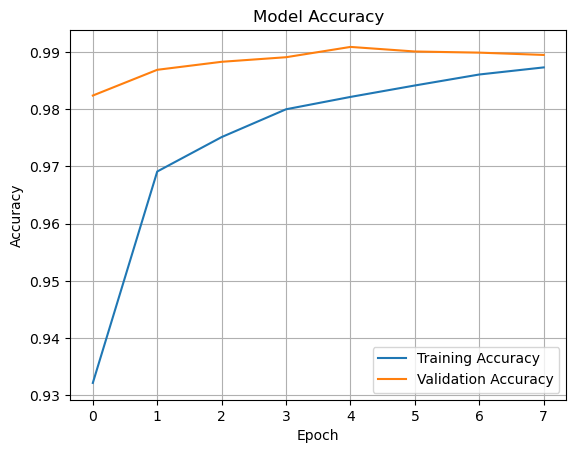

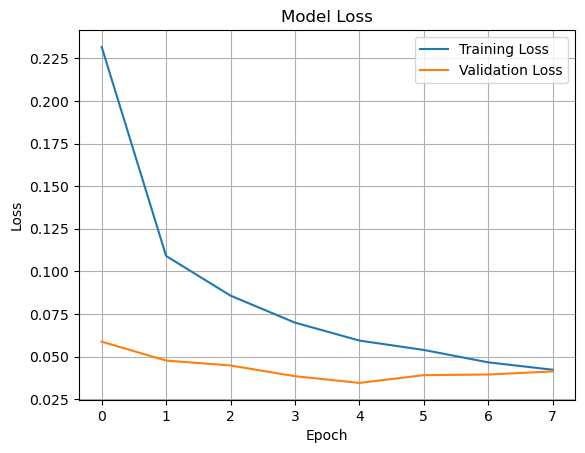

In [ ]:
import matplotlib.pyplot as plt

# training & validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

We see that the training and validation accuracy goes up together, and then plateaus around 0.99 for the validation accuracy. This indicated that the model is learning well, and not overfitting.

The validation loss stays hovered around 0.03-0.05, while the training data lowers down to match it. When these two values have been close enough for 3 epochs, the models stops training due to lack of significant improvement.

## Conclusion

This exercise was about trying to create a convolutional neural network, and see how high accuracy we could get on the MNIST dataset. CNN's is a particularly good model to use for this dataset, since it is designed to process grid-structured data, which this dataset is.

Our CNN consists of convolution layers, which slide small filters (kernels) over the data, which detects features in the data. These features are then combined across layers to form higher-level representation of the data. We use several of these layers, but between each of them, we also use pooling layers, to decrease dimensionality and batch normalization, which stabilizes learning. We also use some dropout layers, which randomly deactivates some neurons, that in turn improves generalization.

We tried several different iterations of the model, adding/removing layers, changing hyperparameters, to see how the performance of the model changed. Our goal was to hit an accuracy of >0.99, which we eventually achieved.

In conclusion, using a CNN has given us the best result on the MNIST dataset so far, considerably better than the models we have tried previously on the dataset, like the linear regression.

### Sources

Lesson 7 slides 25 for starting code

For layer inspiration and model buildup
https://keras.io/guides/sequential_model/


# Learning Curves

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/dl_generalization_error.png" alt="WARNING: could not get image from server." style="height:500px">


## Qa - Figure explanation

### Training and generalization error

When training a model, some loss function is often used to measure how good it is at doing its job. This can not just be used to measure how good it is at predicting new data, but also be used during training, to see the error it makes in the training data itself. So during training, before it trains on a certain data point, it checks its prediction for it first, and then measures the error from the actual value. This gives us the training error, which is a measurement of how well our model predict the training data. But just because it is good at that, does not mean it is good on test/actual data.

Generalization is found the same way, but just with the test data instead. This indicates how well our model can predict new data, after training on the training data.

### Underfit/overfit zone

Underfitting is when our model is not good enough to even predict its own training data. This is what happens early in the models training, when it hasn't run for very long. This can also happen if there is not enough data to train on, and the model is unable to become good enough.

Opposite the underfit zone, we have the overfit zone. This is when our model trains 'too well', meaning that it becomes so good at predicting the training data, that it fails on real data. here the training error will be extremely small, but the generalization error is much larger.

### Optimal capacity

Between the underfit/overfit zones, there is an optimal capacity, where the model is good at both predicting new training data, and test data with low errors. This is where you usually want to stop the training, since training it further probably will just push it into the overfitting zone.

### Generalization gap

The generalization gap is the difference between the error the model predicts on new training data vs test data. If there is a large difference, the model is probably overfitting. You want these to be close together, but not exactly the same. If they are, you have probably made a mistake somewhere, like using testdata to train on.

### Axes explained

The y-axis is the calculated error, for both the training and test data. The larger it is, the worse prediction the model is making.

The x-axis is the models capacity, which refers to the models ability to fit a variety of functions and patterns in the data. If the capacity is too small, it will be like trying to do a linear fit on very advanced and varying datasets. This will make it give quite bad predictions on test data.

If the capacity is too large, it will fit too well on training data. We can imagine that the training data is not very varied or advanced, and our model is so advanced and has such a high capacity, that given enough training, it just produces a line between each data point. Then it will be extremely good at predicting the training data, but awful at new test data.


## Qb - Learning curves


LossHistory function was added to the `MyLinReg` class by adding it as another `self.` variable, and initializing it to an empty array. Then everytime we run a fit function, either the BGD or SGD version, we just append the loss from each epoch to the array.

```python
def __init__(self, eta0=0.10, max_iter=1000, tol=1e-5, n_iter_no_change=5, verbose=True):
    self.train_loss_history_ = []
    self.val_loss_history_ = []

def TrainLossHistory(self):
    return self.train_loss_history_
```

In addition the lossHistory is split into to train_lost_history and val_lost_history, so the class can calculate the generalization gap in exercise Qc


In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import add_dummy_feature
import numpy as np

class MyLinReg(BaseEstimator, RegressorMixin):
    def __init__(self: 'MyLinReg', eta0=0.01, max_iter=10000, tol=1e-4, n_iter_no_change=10, validation_split=0.0, verbose=True):
        self.eta0: float = eta0
        self.max_iter: int = max_iter
        self.tol: float = tol
        self.n_iter_no_change: int = n_iter_no_change
        self.validation_split: float = validation_split
        self.verbose: bool = verbose
        self.intercept_: float = 0.0 # dummy init value
        self.coef_: np.ndarray = np.array([0.0]) # dummy init value
        self.train_loss_history_ = [] 
        self.val_loss_history_ = []

    def _MSE(self: 'MyLinReg', y_pred: np.ndarray, y_true: np.ndarray) -> float:
        assert len(y_pred) == len(y_true) and y_pred.ndim == 1 and y_true.ndim == 1
        err_vec = y_pred - y_true # Xw - y
        return np.mean(err_vec ** 2)

    # loss function isnt used. But could be used in terms of early stopping.
    def _loss(self: 'MyLinReg', X, y) -> float:
        y_pred = self.predict(X)
        return self._MSE(y_pred, y)

    def __str__(self: 'MyLinReg') -> str: 
        return "MyLinReg.__str__(): hi!"

    def fit(self: 'MyLinReg', X: np.ndarray, y: np.ndarray) -> None:        
        self.train_loss_history_ = [] # reset history
        self.val_loss_history_ = []   # reset history

        X_train, y_train = X, y
        X_val, y_val = None, None # Init
        
        # Split data if validation_split is set
        if self.validation_split > 0.0 and self.validation_split < 1.0:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=self.validation_split, random_state=42
            )
        else:
            X_val, y_val = X_train, y_train

        # Run batch or stocastich
        self._batch(X_train, y_train, X_val, y_val)
        # self._sgd(X_train, y_train, X_val, y_val)
        return self

    def predict(self: 'MyLinReg', X: np.ndarray) -> np.ndarray:
        return X @ self.coef_ + self.intercept_
    
    def _batch(self: 'MyLinReg', X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        # Add bias term
        X_b = add_dummy_feature(X)
        X_val_b = add_dummy_feature(X_val)

        n_samples, n_features = X_b.shape
        np.random.seed(42)
        theta = np.random.randn(n_features, 1) # random initialization of parameters

        best_val_loss = np.inf # infinity
        no_improvement_count = 0

        for epoch in range(self.max_iter):
            # Compute predictions: X w
            y_pred_train = X_b @ theta

            # Compute gradient: (2/n) X_b^T (y_pred - y)
            gradient = (2.0 / n_samples) * X_b.T @ (y_pred_train - y.reshape(-1, 1))
            
            # Update theta
            theta -= self.eta0 * gradient

            # Calculate training loss
            train_loss = self._MSE(y_pred_train.ravel(), y.ravel())
            self.train_loss_history_.append(train_loss)
            
            # Calculate validation loss
            y_pred_val = X_val_b @ theta
            val_loss = self._MSE(y_pred_val.ravel(), y_val.ravel())
            self.val_loss_history_.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss - self.tol:
                best_val_loss = val_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            if no_improvement_count >= self.n_iter_no_change:
                if self.verbose:
                    print(f"Stopping early at epoch {epoch} (Batch GD). Validation loss stopped improving.")
                break

        # Store final parameters
        self.intercept_ = float(theta.ravel()[0])
        self.coef_ = theta[1:].ravel()
                
    # its kinda funny how "unpredictable" SGD is. You can really finetune with all the hyperparameters(and you have to)
    def _sgd(self: 'MyLinReg', X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        # Add bias term
        X_b = add_dummy_feature(X)
        X_val_b = add_dummy_feature(X_val)

        n_samples, n_features = X_b.shape
        np.random.seed(42)
        theta = np.random.randn(n_features, 1) # random initialization of parameters

        best_val_loss = np.inf # infinity
        no_improvement_count = 0

        for epoch in range(self.max_iter):
            # Shuffle data, this means there is no "tilbagelægning" during an epoch
            indices = np.random.permutation(n_samples)
            # This part is almost identical to HOML, but without the learning schedule(variable eta)
            for i in indices:
                xi = X_b[i:i+1]
                yi = y[i:i+1]

                # Prediction
                y_pred_i = xi @ theta

                # Compute gradient: 2 X_b^T (y_pred - y)
                gradient = 2.0 * xi.T @ (y_pred_i - yi.reshape(-1, 1))

                # Update theta
                theta -= self.eta0 * gradient
            
            # Calculate training loss
            y_pred_train = X_b @ theta
            train_loss = self._MSE(y_pred_train.ravel(), y.ravel())
            self.train_loss_history_.append(train_loss)

            # Calculate validation loss
            y_pred_val = X_val_b @ theta 
            val_loss = self._MSE(y_pred_val.ravel(), y_val.ravel())
            self.val_loss_history_.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss - self.tol:
                best_val_loss = val_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            if no_improvement_count >= self.n_iter_no_change:
                if self.verbose:
                    print(f"Stopping early at epoch {epoch} (SGD). Validation loss stopped improving.")
                break

        # Store final parameters
        self.intercept_ = float(theta.ravel()[0])
        self.coef_ = theta[1:].ravel()

    def TrainLossHistory(self):
        return self.train_loss_history_

Stopping early at epoch 171 (Batch GD). Validation loss stopped improving.


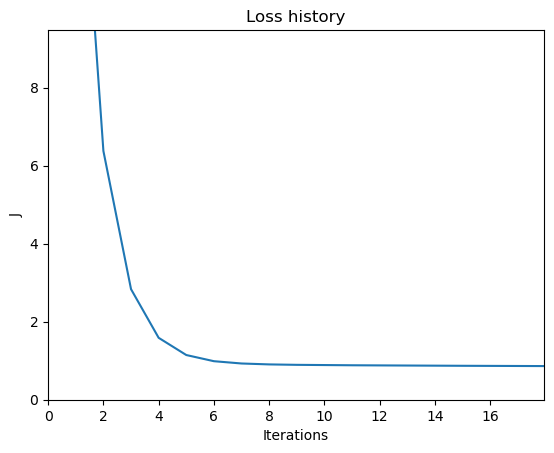

OK


In [10]:
import numpy as np

# Some dummy linear data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Train your model
r = MyLinReg(eta0=0.1, max_iter=1000, tol=1e-6, verbose=True)
r.fit(X, y)

h = r.TrainLossHistory()

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(h)

ax.set_title("Loss history")
ax.set_xlabel("Iterations")
ax.set_ylabel("J")

zoom_axis = True
if zoom_axis:
    limits_x = ax.get_xlim()
    limits_y = ax.get_ylim()
    ax.set_ylim([0, limits_y[1]/5]) # zoom on y axis
    ax.set_xlim([0, limits_x[1]/10]) # zoom on x axis
    
plt.show()

print("OK")

### Qc Early stopping

Early stopping is a term for stopping the models training, when it reaches a point where it is no longer improving, so we dont risk overfitting. This is where validation data is very useful. By fitting the current model on some validation-test data, while it is training on some training data, we can see both its training error, and generalization error during training.

Early stopping should then be implemented in a way where it checks how the generalization error evolves over iterations/epochs. If its change becomes extremely low over a longer period of time, or it start becoming worse, the model stops training to not risk overfitting, and we should end up very close to the optimal capacity.


Stopping early at epoch 254 (Batch GD). Validation loss stopped improving.


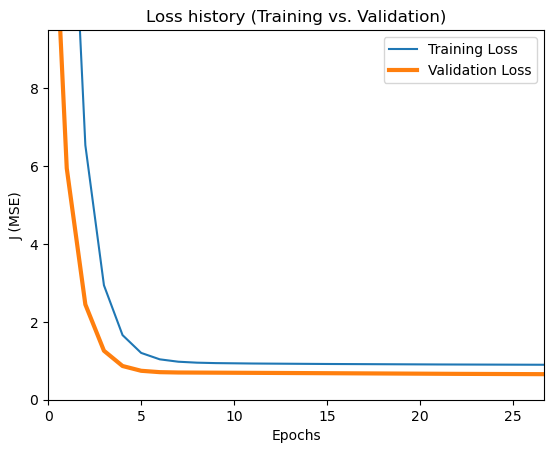

OK


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# model (set to use batch GD)
r = MyLinReg(eta0=0.1, max_iter=1000, tol=1e-6, 
             validation_split=0.2, n_iter_no_change=5, verbose=True)
r.fit(X, y)

%matplotlib inline
fig, ax = plt.subplots()

plt.plot(r.train_loss_history_, label="Training Loss")
plt.plot(r.val_loss_history_, label="Validation Loss", linewidth=3)
ax.legend()

ax.set_title("Loss history (Training vs. Validation)")
ax.set_xlabel("Epochs")
ax.set_ylabel("J (MSE)")

zoom_axis = True
if zoom_axis:
    limits_x = ax.get_xlim()
    limits_y = ax.get_ylim()
    ax.set_ylim([0, limits_y[1]/5])
    ax.set_xlim([0, limits_x[1]/10])
    
plt.show()

print("OK")

# Grid Search


### Changes

There are a few additions made by the group.

1. Ignoring warnings, since running with low max iterations would result in ConvergenceWarnings.
2. SummarizeParamPerformance, which is used during random search to prune the possible hyperparameter candidates. When used later it will be explained.
3. When running on the cluster the results are written to a file using the WriteReportToFile function.

### Code review

#### Cell 1

The LoadAndSetupData function simply loads whichever dataset is desired and splits it into training and test sets.
Then there are several functions that print out information using the grid_tune object. It prints the best parameters and scores based on those parameters.

#### Cell 2

First up the call to `LoadAndSetupData` is made to get the Iris dataset.
Then the base model is chosen to be a Support Vector Classifier with the hyperparameter "gamma" set to 0.001.

Then the hyperparameters that are to be searched are defined. Here, 2 different kernels, linear and rbf are selected. The C parameter should also be searched with values 0.1, 1 and 10. This means that 2\*3 combinations are to be trained and scored.

The GridSearch uses 5 cross validations. So you could say that it is 2\*3\*5 models that are to be trained and scored.

The scoring is set to `f1_micro`, which takes all the results from the confusion matrix from all the different classes and computes a single F1 score from this. That means that no class is favoured.(https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult)

`n_jobs=-1` just means "run on as many cpus/cores as possible, which will parallelize and speed up the grid search.

The grid search implements the fit predict interface and is used first to fit and then in the FullReport which tells us about the best model.

Apparently the best combination in our case is `SVC(C=1, gamma=0.001, kernel='linear')` yielding a score of 0.97143.


In [ ]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

from time import time
import numpy as np

from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import datasets

from libitmal import dataloaders as itmaldataloaders # Needed for load of iris, moon and mnist

# The following function was made by ChatGPT to display the average values of different parameters.
# It should be usefull to quickly sort out any really bad parameters.
def SummarizeParamPerformance(search, param='loss', sort=True):
    results = search.cv_results_
    params = np.array(results[f'param_{param}'], dtype=object)
    scores = np.array(results['mean_test_score'])

    unique_params = np.unique(params)
    summary = []
    for val in unique_params:
        mask = params == val
        mean_score = np.mean(scores[mask])
        std_score = np.std(scores[mask])
        summary.append((val, mean_score, std_score))

    if sort:
        summary.sort(key=lambda x: x[1], reverse=True)

    print(f"\nAverage CV score per '{param}':")
    for val, mean_score, std_score in summary:
        print(f"  {param}={val!s:15}  mean_f1_micro={mean_score:.4f}  (+/- {std_score:.4f})")

def WriteReportToFile(grid_tuned, X_test, y_test, t, params_to_summarize=None, 
                      full_results_file='search_results.txt', 
                      status_file='search_status.txt'):

    import sys
    from io import StringIO
    
    # Capture all output to a string buffer
    output_buffer = StringIO()
    old_stdout = sys.stdout
    sys.stdout = output_buffer
    
    b0, m0 = FullReport(grid_tuned, X_test, y_test, t)
    
    # Go through the specified parameters
    if params_to_summarize:
        for param in params_to_summarize:
            SummarizeParamPerformance(grid_tuned, param)
    
    print('OK(random-grid-search)')
    print(b0)
    
    # Restore stdout just to be safe
    sys.stdout = old_stdout
    
    # Write full report to file
    with open(full_results_file, 'w') as f:
        f.write(output_buffer.getvalue())
    
    # Write just the OK and best model to a separate file
    with open(status_file, 'w') as f:
        f.write('OK(random-grid-search)\n')
        f.write(f'{b0}\n')
    
    print(f"Results written to {full_results_file} and {status_file}")
    
    return b0, m0

currmode="N/A" # GLOBAL var!

def SearchReport(model): 
    
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            ret_str=""          
            for key in sorted(best_params):
                value = best_params[key]
                temp_str = "'" if str(type(value))=="<class 'str'>" else ""
                if len(ret_str)>0:
                    ret_str += ','
                ret_str += f'{key}={temp_str}{value}{temp_str}'  
            return ret_str          
        try:
            param_str = GetParams(best_params)
            return type(model).__name__ + '(' + param_str + ')' 
        except:
            return "N/A(1)"
        
    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    """
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        stds  = model.cv_results_['std_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")
    """
    
    global currmode                
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"   
    return f"best: dat={currmode}, score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_ 

def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)                 
    print(classification_report(y_true, y_pred, target_names=target_names))
    print()
    
def FullReport(model, X_test, y_test, t):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)    
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel
    
def LoadAndSetupData(mode, test_size=0.3):
    assert test_size>=0.0 and test_size<=1.0
    
    def ShapeToString(Z):
        n = Z.ndim
        s = "("
        for i in range(n):
            s += f"{Z.shape[i]:5d}"
            if i+1!=n:
                s += ";"
        return s+")"

    global currmode
    currmode=mode
    print(f"DATA: {currmode}..")
    
    if mode=='moon':
        X, y = itmaldataloaders.MOON_GetDataSet(n_samples=5000, noise=0.2)
        itmaldataloaders.MOON_Plot(X, y)
    elif mode=='mnist':
        X, y = itmaldataloaders.MNIST_GetDataSet(load_mode=0)
        if X.ndim==3:
            X=np.reshape(X, (X.shape[0], -1))
    elif mode=='iris':
        X, y = itmaldataloaders.IRIS_GetDataSet()
    else:
        raise ValueError(f"could not load data for that particular mode='{mode}', only 'moon'/'mnist'/'iris' supported")
        
    print(f'  org. data:  X.shape      ={ShapeToString(X)}, y.shape      ={ShapeToString(y)}')

    assert X.ndim==2
    assert X.shape[0]==y.shape[0]
    assert y.ndim==1 or (y.ndim==2 and y.shape[1]==0)    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, shuffle=True
    )
    
    print(f'  train data: X_train.shape={ShapeToString(X_train)}, y_train.shape={ShapeToString(y_train)}')
    print(f'  test data:  X_test.shape ={ShapeToString(X_test)}, y_test.shape ={ShapeToString(y_test)}')
    print()
    
    return X_train, X_test, y_train, y_test

def TryKerasImport(verbose=True):
    
    kerasok = True
    try:
        import keras as keras_try
    except:
        kerasok = False

    tensorflowkerasok = True
    try:
        import tensorflow.keras as tensorflowkeras_try
    except:
        tensorflowkerasok = False
        
    ok = kerasok or tensorflowkerasok
    
    if not ok and verbose:
        if not kerasok:
            print("WARNING: importing 'keras' failed", file=sys.stderr)
        if not tensorflowkerasok:
            print("WARNING: importing 'tensorflow.keras' failed", file=sys.stderr)

    return ok
    
print(f"OK(function setup" + ("" if TryKerasImport() else ", hope MNIST loads works because it seems you miss the installation of Keras or Tensorflow!") + ")")

OK(function setup)


In [ ]:

# Setup data
X_train, X_test, y_train, y_test = LoadAndSetupData(
    'iris')  # 'iris', 'moon', or 'mnist'

# Setup search parameters
model = svm.SVC(
    gamma=0.001
)  # NOTE: gamma="scale" does not work in older Scikit-learn frameworks,
# FIX:  replace with model = svm.SVC(gamma=0.001)

tuning_parameters = {
    'kernel': ('linear', 'rbf'), 
    'C': [0.1, 1, 10]
}

CV = 5
VERBOSE = 0

# Run GridSearchCV for the model
grid_tuned = GridSearchCV(model,
                          tuning_parameters,
                          cv=CV,
                          scoring='f1_micro',
                          verbose=VERBOSE,
                          n_jobs=-1)

start = time()
grid_tuned.fit(X_train, y_train)
t = time() - start

# Report result
b0, m0 = FullReport(grid_tuned, X_test, y_test, t)
print('OK(grid-search)')

DATA: iris..
  org. data:  X.shape      =(  150;    4), y.shape      =(  150)
  train data: X_train.shape=(  105;    4), y_train.shape=(  105)
  test data:  X_test.shape =(   45;    4), y_test.shape =(   45)

SEARCH TIME: 6.30 sec

Best model set found on train set:

	best parameters={'C': 1, 'kernel': 'linear'}
	best 'f1_micro' score=0.9714285714285715
	best index=2

Best estimator CTOR:
	SVC(C=1, gamma=0.001, kernel='linear')


Detailed classification report:
	The model is trained on the full development set.
	The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


CTOR for best model: SVC(C=1, gamma=0.001, kern

### Qb Hyperparameter Grid Search using an SDG classifier

We set up a lot of hyperparameters and combinations to search through. There is no real structure other than the numerical values increasing by a factor 10.


In [ ]:
# TODO: grid search
# Setup data. Done above already
#X_train, X_test, y_train, y_test = LoadAndSetupData('iris')  # 'iris', 'moon', or 'mnist'

model = SGDClassifier()

tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    'eta0': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2500, 5000, 10000, 20000],
    'shuffle': [True, False],
    'average': [False, True],
    'early_stopping': [False, True],
}

CV = 5
VERBOSE = 0

# Run GridSearchCV for the model
grid_tuned = GridSearchCV(model,
                          tuning_parameters,
                          cv=CV,
                          scoring='f1_micro',
                          verbose=VERBOSE,
                          n_jobs=-1)

start = time()
grid_tuned.fit(X_train, y_train)
t = time() - start

b0, m0 = WriteReportToFile(
    grid_tuned, X_test, y_test, t,
    params_to_summarize=None,
    full_results_file='mnist_search_results_iris_cv.txt',
    status_file='mnist_search_status_iris_cv.txt'
)

#### Output

best: data=iris, score=1.00000, model=SGDClassifier(alpha=0.01,average=False,early_stopping=False,eta0=1e-05,learning_rate='optimal',loss='modified_huber',max_iter=1000,penalty='l1',shuffle=False)

SEARCH TIME: 122.54 sec

Best model set found on train set:

```py
best parameters={'alpha': 0.01,
	'average': False,
	'early_stopping': False,
	'eta0': 1e-05,
	'learning_rate': 'optimal',
	'loss': 'modified_huber',
	'max_iter': 1000,
	'penalty': 'l1',
	'shuffle': False}
```

    best 'f1_micro' score=1.0
    best index=28981

Best estimator CTOR:

```py
SGDClassifier(alpha=0.01,
	eta0=1e-05,
	loss='modified_huber',
	penalty='l1',
	shuffle=False)
```

#### Comments on the run:

We can see that the search 2 minutes, which isnt a long time, but the number of trained models is <=28981.
If the dataset was bigger, training time would explode.

The best score is 1, which should be concerning, but the iris dataset is so small so its alright in this case.


### Qc Hyperparameter Random Search using an SDG classifier

The n_iter parameter is the number of random combinations to test. We could have 4 loss functions, 3 penalty and 4 learning rates which would at least mean 4\*3\*4 = 48 models. However, if we set n-iter to 20, we are guaranteed to only get that amount of models.
We can then quickly test a lot of random combinations and possibly rule out parameters that are not a good fit for the use case.

Another advantage with the random search is that an interval can be specified rather than fixed values. There is the potential to get a lucky hit on a random number that just increases the scores dramatically(although it should be unlikely).


In [ ]:
# Setup data. Done above already
#X_train, X_test, y_train, y_test = LoadAndSetupData('iris')  # 'iris', 'moon', or 'mnist'

from scipy.stats import uniform, loguniform, randint
model = SGDClassifier()

tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    'alpha': loguniform(0.000001, 0.1),
    'eta0': loguniform(0.00001, 0.1),
    'max_iter': randint(1000, 20000),
    'shuffle': [True, False],
    'average': [False, True],
    'early_stopping': [False, True],
}

CV = 5
VERBOSE = 0

# Run RandomizedSearchCV for the model
grid_tuned = RandomizedSearchCV(model,
                          tuning_parameters,
                          n_iter=100,
                          random_state=42,
                          cv=CV,
                          scoring='f1_micro',
                          verbose=VERBOSE,
                          n_jobs=-1)

start = time()
grid_tuned.fit(X_train, y_train)
t = time() - start

# Report result
b0, m0 = FullReport(grid_tuned, X_test, y_test, t)

SummarizeParamPerformance(grid_tuned)
print('OK(grid-search)')

#### Output

best: dat=iris, score=0.99048, model=SGDClassifier(alpha=0.024169519319206773,average=False,early_stopping=False,eta0=3.4360613844702604e-05,learning_rate='optimal',loss='modified_huber',max_iter=12470,penalty='l1',shuffle=True)

SEARCH TIME: 2.90 sec

Best model set found on train set:

```py
best parameters={
'alpha': 0.024169519319206773,
'average': False,
'early_stopping': False,
'eta0': 3.4360613844702604e-05,
'learning_rate': 'optimal',
'loss': 'modified_huber',
'max_iter': 12470,
'penalty': 'l1',
'shuffle': True}
```

    best 'f1_micro' score=0.9904761904761905
    best index=92

Best estimator CTOR:

```py
SGDClassifier(alpha=0.024169519319206773,
	eta0=3.4360613844702604e-05,
	loss='modified_huber',
	max_iter=12470,
	penalty='l1')
```

```py
SGDClassifier(alpha=0.01,
	eta0=1e-05,
	loss='modified_huber',
	penalty='l1',
	shuffle=False)
```

#### Comments on the run

The random search that tests 100 random models takes just 3 seconds to run, which is 1/60 of the time. The best model scores 0.99, which is also very high, but again, the dataset is very small. We see that they both find the same loss and penalty functions to be best. The differences are mostly at the alpha and eta0 values. With more models tested we might achieve close to the same values.

One thing that is nice about the random search is that it scales linearly in time. So doubling n_iter, will take twice the time(disregarding the early stopping).


### Qd MNIST Search Quest II

This quest is in two parts. The first part is where we tried to use an SGD classifier and the second where we use the SVC.

#### SGD

Initially we thought using the SGD would be okay since it scored well with the IRIS dataset and it specified as a replacement for SVC if datasets are large. We went through 3 different searches all using the random approach. After each run we looked at which parameters gave the worst scores and removed them from testing.

For all the tests we scaled the data using the StandardScaler(we did not go back and try to remove it).

The final result is 0.9207, which is posted to Brightspace as the first official attempt.


In [ ]:
from time import time
import numpy as np
from scipy.stats import loguniform, randint
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = LoadAndSetupData('mnist')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SGDClassifier()

# reference for why the loguniform is used.
#https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

# Trying all the loss, penalty and learning_rate options
tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    'alpha': loguniform(0.000001, 0.1),
    'eta0': loguniform(0.00001, 0.1),
    'max_iter': randint(1000, 20000),
    'shuffle': [True, False],
    'average': [False, True],
    'early_stopping': [False, True],
}

CV = 5
VERBOSE = 0

grid_tuned = RandomizedSearchCV(
    model,
    tuning_parameters,
    n_iter=200,              # will take a couple hours
    random_state=42,
    cv=CV,
    scoring='f1_micro',
    verbose=VERBOSE,
    n_jobs=-1
)

start = time()
grid_tuned.fit(X_train, y_train)
t = time() - start

b0, m0 = WriteReportToFile(
    grid_tuned, X_test, y_test, t,
    params_to_summarize=['loss', 'penalty', 'learning_rate', 'shuffle', 'average', 'early_stopping'],
    full_results_file='mnist_search_results.txt',
    status_file='mnist_search_status.txt'
)

CV = 5

### Run 1

#### Input

Trying all the loss, penalty and learning_rate options

```py
tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    'alpha': loguniform(0.000001, 0.1),
    'eta0': loguniform(0.00001, 0.1),
    'max_iter': randint(1000, 20000),
    'shuffle': [True, False],
    'average': [False, True],
    'early_stopping': [False, True],
}
```

CV = 5

VERBOSE = 0

```py
grid_tuned = RandomizedSearchCV(
    model,
    tuning_parameters,
    n_iter=200,              # will take a couple hours
    random_state=42,
    cv=CV,
    scoring='f1_micro',
    verbose=VERBOSE,
    n_jobs=-1
)
```

#### Output

SEARCH TIME: 9788.79 sec

best: dat=mnist, score=0.91400,

```py
model=SGDClassifier(alpha=3.46979613767106e-05,
  average=True,
  early_stopping=True,
  eta0=0.0010845668034236337,
  learning_rate='optimal',
  loss='modified_huber',
  max_iter=18429,
  penalty='l2',
  shuffle=False)
```

#### Parameter information

```
Average CV score per 'loss':
  loss=modified_huber   mean_f1_micro=0.8491  (+/- 0.1689)
  loss=squared_hinge    mean_f1_micro=0.8143  (+/- 0.1880)
  loss=hinge            mean_f1_micro=0.7767  (+/- 0.2730)
  loss=log_loss         mean_f1_micro=0.7235  (+/- 0.3143)

Average CV score per 'penalty':
  penalty=l2               mean_f1_micro=0.8744  (+/- 0.0628)
  penalty=elasticnet       mean_f1_micro=0.7799  (+/- 0.2627)
  penalty=l1               mean_f1_micro=0.7362  (+/- 0.3033)

Average CV score per 'learning_rate':
  learning_rate=optimal          mean_f1_micro=0.8213  (+/- 0.2332)
  learning_rate=invscaling       mean_f1_micro=0.7971  (+/- 0.1656)
  learning_rate=constant         mean_f1_micro=0.7790  (+/- 0.2879)
  learning_rate=adaptive         mean_f1_micro=0.7774  (+/- 0.2857)

Average CV score per 'shuffle':
  shuffle=False            mean_f1_micro=0.8069  (+/- 0.2175)
  shuffle=True             mean_f1_micro=0.7765  (+/- 0.2759)

Average CV score per 'average':
  average=False            mean_f1_micro=0.8623  (+/- 0.0559)
  average=True             mean_f1_micro=0.7240  (+/- 0.3292)

Average CV score per 'early_stopping':
  early_stopping=True             mean_f1_micro=0.8374  (+/- 0.1720)
  early_stopping=False            mean_f1_micro=0.7413  (+/- 0.3031)
```

This uses the created function mentioned in the beginning. We remove the parameters that score low and have a high variation, since they are unlikely to settle down.
Then we start another round of searching. Please note that the search time is ~3 hours and yields a score of 0.914.


### Run 2

#### Input

```py
tuning_parameters = {
    'loss': ['hinge', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'elasticnet'],
    'learning_rate': ['adaptive', 'optimal'],
    'alpha': loguniform(0.000001, 0.01),
    'eta0': loguniform(0.0001, 0.1),
    'max_iter': randint(5000, 60000),
    'n_iter_no_change': [10],
    'early_stopping': [True],
    'shuffle': [True],
    'average': [True, False],
}
```

CV = 5

VERBOSE = 0

```py
grid_tuned = RandomizedSearchCV(
    model,
    tuning_parameters,
    n_iter=200, # will take a couple hours
    random_state=42,
    cv=CV,
    scoring='f1_micro',
    verbose=VERBOSE,
    n_jobs=-1
)
```

#### Output

SEARCH TIME: 4805.65 sec

best: dat=mnist, score=0.91937,

```py
model=SGDClassifier(
  alpha=0.0010316033434719725,
  average=False,
  early_stopping=True,
  eta0=0.013321207301714324,
  learning_rate='adaptive',
  loss='hinge',
  max_iter=57075,
  n_iter_no_change=10,
  penalty='elasticnet',
  shuffle=True,
  validation_fraction=0.1)
```

#### Parameter information

```
Average CV score per 'loss':
  loss=squared_hinge    mean_f1_micro=0.8953  (+/- 0.0304)
  loss=modified_huber   mean_f1_micro=0.8801  (+/- 0.1539)
  loss=hinge            mean_f1_micro=0.8690  (+/- 0.1768)

Average CV score per 'penalty':
  penalty=l2               mean_f1_micro=0.9033  (+/- 0.0195)
  penalty=elasticnet       mean_f1_micro=0.8571  (+/- 0.1960)

Average CV score per 'learning_rate':
  learning_rate=optimal          mean_f1_micro=0.8976  (+/- 0.0854)
  learning_rate=adaptive         mean_f1_micro=0.8601  (+/- 0.1838)

Average CV score per 'shuffle':
  shuffle=True             mean_f1_micro=0.8807  (+/- 0.1398)

Average CV score per 'average':
  average=False            mean_f1_micro=0.9029  (+/- 0.0205)
  average=True             mean_f1_micro=0.8626  (+/- 0.1857)

Average CV score per 'early_stopping':
  early_stopping=True             mean_f1_micro=0.8807  (+/- 0.1398)
```

#### Discussion

We now see that the squared_hinge loss function has the highest average score but with a low variation. In fact, the best model has the lowest average hinge loss function and the lower average elasticnet. This tells us that you can just get a really lucky combination that achieves a higher score. However the modified_huber got neither the highest score or the best model, so we drop that.


### Run 3

#### Input

```py
tuning_parameters = {
    'loss': ['hinge', 'squared_hinge'],     # Dropping modified_huber
    'penalty': ['l2', 'elasticnet'],
    'learning_rate': ['optimal', 'adaptive'],
    'alpha': loguniform(0.00001, 0.005),        # narrowing search around the best parameters found earlier
    'eta0': loguniform(0.001, 0.05),         # narrowing search around the best parameters found earlier
    'max_iter': randint(10000, 80000),      # increasing maximum iterations
    'n_iter_no_change': [10],
    'early_stopping': [True],
    'shuffle': [True],
    'average': [False],
}
```

CV = 5

VERBOSE = 0

```py
grid_tuned = RandomizedSearchCV(
    model,
    tuning_parameters,
    n_iter=200, # will take some hours
    random_state=42,
    cv=CV,
    scoring='f1_micro',
    verbose=VERBOSE,
    n_jobs=-1
)
```

#### Output

SEARCH TIME: 10949.07 sec

best: dat=mnist, score=0.92073,

```py
model=SGDClassifier(alpha=0.0034952182314214584,
  average=False,
  early_stopping=True,
  eta0=0.030463008520733255,
  learning_rate='adaptive',
  loss='hinge',
  max_iter=75450,
  n_iter_no_change=10,
  penalty='l2',
  shuffle=True)
```

#### Parameter information

```
Average CV score per 'loss':
  loss=hinge            mean_f1_micro=0.9115  (+/- 0.0049)
  loss=squared_hinge    mean_f1_micro=0.8978  (+/- 0.0118)

Average CV score per 'penalty':
  penalty=l2               mean_f1_micro=0.9050  (+/- 0.0113)
  penalty=elasticnet       mean_f1_micro=0.9032  (+/- 0.0116)

Average CV score per 'learning_rate':
  learning_rate=optimal          mean_f1_micro=0.9084  (+/- 0.0041)
  learning_rate=adaptive         mean_f1_micro=0.9002  (+/- 0.0144)

Average CV score per 'shuffle':
  shuffle=True             mean_f1_micro=0.9041  (+/- 0.0115)

Average CV score per 'average':
  average=False            mean_f1_micro=0.9041  (+/- 0.0115)

Average CV score per 'early_stopping':
  early_stopping=True             mean_f1_micro=0.9041  (+/- 0.0115)
```

#### Discussion

We decided to stop searching using the SGD classifier since we barely got an increase in score. Looking at the variance there isnt much room for improvement.


#### SVC

Now we try the SVC which has fewer parameters than the SGD. The most important however is the kernel. We chose the rbf kernel since it is the best at multi-class classification when looking throught he scikit learn documentation. https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py

We do NOT scale the data. We found that scaling yielded a worse score than not scaling at all.
Due to this late revelation there are not that many runs.

The first best score was 0.96949 and was a good increase.

The approach was similar to the SGD, but search time is way longer since it scales horribly with bigger datasets and thus fewer combinations could be tested per run.

Initially we just used the "auto" and "scale" gamma parameters, to avoid having too many variables.


In [ ]:
from time import time
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = LoadAndSetupData('mnist')

from sklearn.svm import SVC
model = SVC(kernel='rbf')

tuning_parameters = {
    'C': [4]
}

CV = 5
VERBOSE = 0

grid_tuned = GridSearchCV(
    model,
    tuning_parameters,
    cv=CV,
    scoring='f1_micro',
    verbose=VERBOSE,
    n_jobs=-1
)

start = time()
grid_tuned.fit(X_train, y_train)
t = time() - start

b0, m0 = WriteReportToFile(
    grid_tuned, X_test, y_test, t,
    params_to_summarize=["C"],
    full_results_file='mnist_search_POC_cv.txt',
    status_file='mnist_search_status_POC_cv.txt'
)

#### Output

SEARCH TIME: 362.07 sec

best: dat=mnist, score=0.98210, model=SVC(C=4)

#### Comments

Compared to many runs where the data was scaled and couldnt get above ~96.94, this was a clear improvement and a wider search is needed.
This was just proof of concept, that the data shouldnt be scaled(at least not with the standardscaler).


In [ ]:
from time import time
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = LoadAndSetupData('mnist')

from sklearn.svm import SVC
model = SVC(kernel='rbf')

tuning_parameters = {
    'C': [1, 2, 4, 8, 12, 16, 25, 35, 50],
    'gamma': ['auto', 'scale'], # using the defined options since they are more, well, defined
}

CV = 5
VERBOSE = 0

grid_tuned = GridSearchCV(
    model,
    tuning_parameters,
    cv=CV,
    scoring='f1_micro',
    verbose=VERBOSE,
    n_jobs=-1
)

start = time()
grid_tuned.fit(X_train, y_train)
t = time() - start


b0, m0 = WriteReportToFile(
    grid_tuned, X_test, y_test, t,
    params_to_summarize=["C", "gamma"],
    full_results_file='mnist_search_long_cv.txt',
    status_file='mnist_search_status_long_cv.txt'
)

#### Output

SEARCH TIME: 86285.36 sec

Best model set found on train set:

```py
best parameters={'C': 25, 'gamma': 'scale'}
best 'f1_micro' score=0.9824081632653062
best index=13
```

Best estimator CTOR:
`SVC(C=25)`

CTOR for best model: `SVC(C=25)`

best: dat=mnist, score=0.98241,

```py
model=SVC(C=25,gamma='scale')
```

Average CV score per 'C':

```
C=25               mean_f1_micro=0.5472  (+/- 0.4352)

C=35               mean_f1_micro=0.5472  (+/- 0.4352)

C=50               mean_f1_micro=0.5472  (+/- 0.4352)

C=12               mean_f1_micro=0.5472  (+/- 0.4351)

C=8                mean_f1_micro=0.5472  (+/- 0.4351)

C=16               mean_f1_micro=0.5472  (+/- 0.4351)

C=4                mean_f1_micro=0.5471  (+/- 0.4350)

C=2                mean_f1_micro=0.5462  (+/- 0.4341)

C=1                mean_f1_micro=0.5444  (+/- 0.4323)
```

Average CV score per 'gamma':

```
gamma=scale            mean_f1_micro=0.9815  (+/- 0.0018)

gamma=auto             mean_f1_micro=0.1121  (+/- 0.0000)
```

best: dat=mnist, score=0.98241,

```py
model=SVC(C=25,gamma='scale')
```

#### Comments

Two things are apparent here:

1. The run took 24 hours to complete.
2. The gamma setting auto performed badly.

Based on there two things, we conclude that auto is not a good parameter and it likely struggle to find a suitable fit for the data and thus stalled the search.

However we found a slightly better score so thats nice.

We tried to increase the search up to C=100, but then the gamma value should also be changed to make a difference.


#### Discussion

The benefits of grid search are clear:

1. Using random grid search we can quickly track down a set of suitable parameters that could yield a good model.
2. Then with the grid search we can do a more systematic search and remove even more parameters.
3. Set the processor(CPU or GPU) to just crunch for hours on end without having to manually replace parameters.

Some drawbacks/preconditions:

1. There are no indications when a search is done, we can only estimate based on earlier runs. If the model scales badly, becomes even worse(SVC).
2. You still need to have some idea what the parameters do to get a good search result.
3. Caution should be taken to not select parameters that potentially stall the search by not converging.


# NanoGPT

## Qa, Qb (and some Qc)

### Introduction

In this exercise, we take a step further into the capabilities of neural networks, with the addition of GPT's. I the exercise, we train a model that can guess the next character to be written, with training from a specific body of text.
The GPT works by looking at a window of inputs, of a certain size, and the produces output is a probability distribution of the next most likely token. In larger LLM's, these tokens are whole or parts of words, but in our case, they are just single characters.

### HCA training

The process of training the HCA data, with the AU GPU cluster, starts by first preparing the data, with `make prepare`.

```makefile
.PHONY:prepare
prepare:
	...
	@ test -f data/$(DATASET)/train.bin  || (echo "RUNNING  data/$(DATASET)/prepare.py.." && cd data/$(DATASET) && $(PYTHON) ./prepare.py)
	@ echo PREPARE: all ok!
```

This last step of the prepare command calls the prepare.py file, which basically just creates mappings of characters into interger id's. This is the tokenizing.

Then comes the training part, with `make train`:

```
.PHONY:train
train:
	@# /home/shared/gpt_node_ok.sh
	$(PYTHON) train.py config/train_$(DATASET).py --max_iters=10 --warmup_iters=1 --eval_iters=1 --eval_interval=1
	@ $(MAKE) -s precondition_predict
	@# more parameters --device=mps --compile=False --eval_iters=20 --log_interval=1 --block_size=64 --batch_size=12 --n_layer=4

```

This command initiates the training, and hold a bunch of training parameters that we know from earlier NN trainings. Here's a brief explanation of some of them:

- `max_iters`: This is the maximum number of training iterations/epochs that the model goes through, before training is stopped.
- `block_size`: This is the size of the window of inputs, also called the context, that the model can have.
- `batch_size`: The batch size is the number of training 'examples' from the data, that the model is trained on each iteration.
- `gradient_accumulation_steps`: This is the number of training iterations the model will go through, while accumulating the gradients. After this amount of iterations, only then are the weights updated. This effectively makes the batch_size bigger, and is nice when memory is limited.

These configurations all play together in the training. Each iteration, the model is given `batch_size` amount of training examples. For each of the examples, the model tries to predict the next character, for each sequence in the `block_size`.

- Based on char 1, it tries to predict char 2
- Based on char 1-2, it tries to preduct char 3
- ...
  So a total of `batch_size` \* `block_size` amount of guesses.

Inside the `config/train_hca.py` file, there's more configuration parameters, some of which specify the transformer setup. Here's a few of them:

- `n_embd`: This is the size of the embeddings of the tokens. An embedding is a vector, which represents the token. So 192, means that each token is represented by a 192 dimension vector.
- `n_layer`: This is the amount of layers in the transformer. Each layer processes the input sequentially, before the final prediction is made from the last layer.
- `n_head`: This is the amount of attention heads. All head are used in each layer, and learns to attend to different patterns. Some heads might attend to the nearby characters, and other might look further back or attend to the whole sentence.
- `dropout`: This is the same as in normal neural networks, where a percentage of the nodes are turned off each iteration, in order to avoid some nodes gaining too much significance.
- `learning_rate`: Learning rate is well known from our other ML studies, and specifies how aggressively we adjust the weights after each iteration, during the backwards pass.

During training, we see continuous loss outputs, and sometimes also validation loss outputs. Lower values mean, that the model gives high probability to the right answer, so that is what we want. Validation loss is calculated at some points during training, and shows how the model performes on unseen data.

### HCA Predicting

When the model is trained, it's time to predict.

```makefile
.PHONY:pred
pred: precondition_predict
	$(PYTHON) sample.py --out_dir=out-$(DATASET) --temperature=0.8 --num_samples=2 --start="Der kom en solda"
```

This make command initiates the prediction. We see the start prompt, "Det kom en solda", and the model will try and predict the next characters.

The temperature is a scaler for the predictions. Lower values will make the model be more likely to choose among it's top most predicted tokens, while larger values will make the model choose more erratic or seemingly random tokens.

Inside the sample.py file, there's also options for setting the amount/length of the output, ie, how many new tokens should be generated.

### Other LLM Lingo

Here's an explanation of some more ML lingo when talking about GPT's and LLM's:

- Design matrix $\mathbf{X}$: This is the input to the model, so basically whatever is in the input.txt file.
- Test data $\mathbf{y}\_\textrm{test}\ $: The test data exists inherintly in the input, because the answer to every series of tokens, is the next token in the input. In this sense, the data is auto-labeled.
- Prompting with LLM's: Prompting is the input we feed to the LLM, or more precisely, the art of shaping the input in order for the LLM to work as we want it and make it generate the desired output.

### Our own data

For training on our own data, we choose the Pokemon Wikipedia page. https://en.wikipedia.org/wiki/Pok%C3%A9mon

The text is put into a input.txt file, and we followed the setup guide from the `make help` command. During training, we set the model to 1000 iterations, and tested the result. Here's an output from the training:

![Training Start](img/nanotraining1.png)
![Training End](img/nanotraining2.png)

We see here that we end up with a loss of around 1.449.

Here's a prompt with a temperature of 1.0:

![Temp 1.0](img/predict1.png)

Below is the result of a temperature of 0.1:

![Temp 0.1](img/predict2.png)

Even though the output is not coherent with lower temperature, it is easy to see the different in character/token choice the model makes. It's actual words comming out of the second attempt!

### Conclusion

Even though we didn't expect the model to generate any great output, it's still impressive to see how well it performs with such minimal training. It's only trained on a few pages of input, the training lasts under a minute, and still it's able to produce output that is spelling words correctly, and also gives some hints to the theme of the input text.
No wonder that the the whole of Reddit, Wikipedia, Stack overflow, news articles etc, fed into massive datasets thats trained for days or weeks, can produce the LLM's that seem so clever!


#### Sources

- GITMAL L10 NanoGPT folder
- HOML cp. 13 (embeddings)
- HOML cp. 16
- Claude.ai
